In [95]:
import os
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.font_manager
import seaborn as sns

# Load Data

In [96]:
datadir = 'data'

In [97]:
models = ['ICHEC','CNRM','MPI']

In [98]:
cap_share = {
    m:{
        'ave': pd.read_csv('data/cap_share_all_periods_model_{}.csv'.format(m), index_col=0),
        'per_node': pd.read_csv('data/cap_share_per_node_all_periods_model_{}.csv'.format(m), index_col=[0,1])
    } for m in models}

cap_factor = {
    m:{
        'ave': pd.read_csv('data/cap_factor_input_per_carrier_all_periods_{}.csv'.format(m), index_col=0),
        'per_node': pd.read_csv('data/cap_factor_input_per_carrier_and_node_all_periods_{}.csv'.format(m), index_col=[0,1])
    } for m in models}

In [104]:
gen_share = {
    m:{
        'ave': pd.read_csv('data/gen_share_all_periods_model_{}.csv'.format(m), index_col=0),
        'per_node': pd.read_csv('data/gen_share_per_node_all_periods_model_{}.csv'.format(m), index_col=[0,1])
    } for m in models}

# Load Europe Map

In [99]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd

In [100]:
### read shapefile from naturalearth to geopandas DataFrame (GeoDataFrame)

shapename = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
countries = gpd.read_file(shapename)

### get europe
europe = countries.loc[countries.index[countries.CONTINENT=='Europe'],:]

### drop entries
europe.drop(europe.index[europe.NAME=='Russia'], inplace=True)
# Update missing ISO_A2 identifier
europe.loc[europe.NAME=='Norway', 'ISO_A2'] = 'NO'
europe.loc[europe.NAME=='France', 'ISO_A2'] = 'FR'
# set index to ISO_A2 identifier
europe.set_index('ISO_A2', inplace=True);
europe.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
ISO_A2,,,,,,,,,,,,,,,,,,,,,
VA,Admin-0 country,6,6,Vatican,VAT,0,2,Sovereign country,Vatican,VAT,...,바티칸 시국,Vaticaanstad,Watykan,Vaticano,Ватикан,Vatikanstaten,Vatikan,Thành Vatican,梵蒂冈,"POLYGON ((12.43916 41.89839, 12.43057 41.89756..."
JE,Admin-0 country,4,6,United Kingdom,GB1,1,2,Country,Jersey,JEY,...,저지 섬,Jersey,Jersey,Jersey,Джерси,Jersey,Jersey,Jersey,澤西島,"POLYGON ((-2.01865 49.23125, -2.00991 49.18081..."


# Add average capacity factor and capacity shares to europe gdp

In [101]:
ref_period = '1970-1976'
for i, m in enumerate(models):
    for carrier in ['onwind', 'offwind']:
    # m = models[0]
#         carrier = 'offwind'
        # capacity factor mean
        key_factor = 'mean cap factor {} {}'.format(carrier, m)
        europe[key_factor] = 0
        cap_factor_m = cap_factor[m]['per_node'].xs(carrier, axis=0, level=1)

        cf_m_carrier = cap_factor_m.mean(axis=1) # mean over all periods
        europe[key_factor].loc[cf_m_carrier.index] = cf_m_carrier

        # capacity share mean
        key_share = 'mean cap share {} {}'.format(carrier, m)
        europe[key_share] = 0
        cap_share_m = cap_share[m]['per_node'].xs(carrier, axis=0, level=1)
        cs_m_carrier = cap_share_m.mean(axis=1) # mean over all periods
        
        europe[key_share].loc[cf_m_carrier.index] = cs_m_carrier
    # europe[[key_factor, key_share]].head()


/home/users/train027/.conda/envs/pypsa-eur/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [108]:
for i, m in enumerate(models):
    carrier = 'onwind'
    key_share = 'mean gen share {} {}'.format(carrier, m)
    europe[key_share] = 0
    gen_share_m = gen_share[m]['per_node'].xs(carrier, axis=0, level=1)
    gs_m_carrier = gen_share_m.mean(axis=1) # mean over all periods

    europe[key_share].loc[gs_m_carrier.index] = gs_m_carrier

/home/users/train027/.conda/envs/pypsa-eur/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


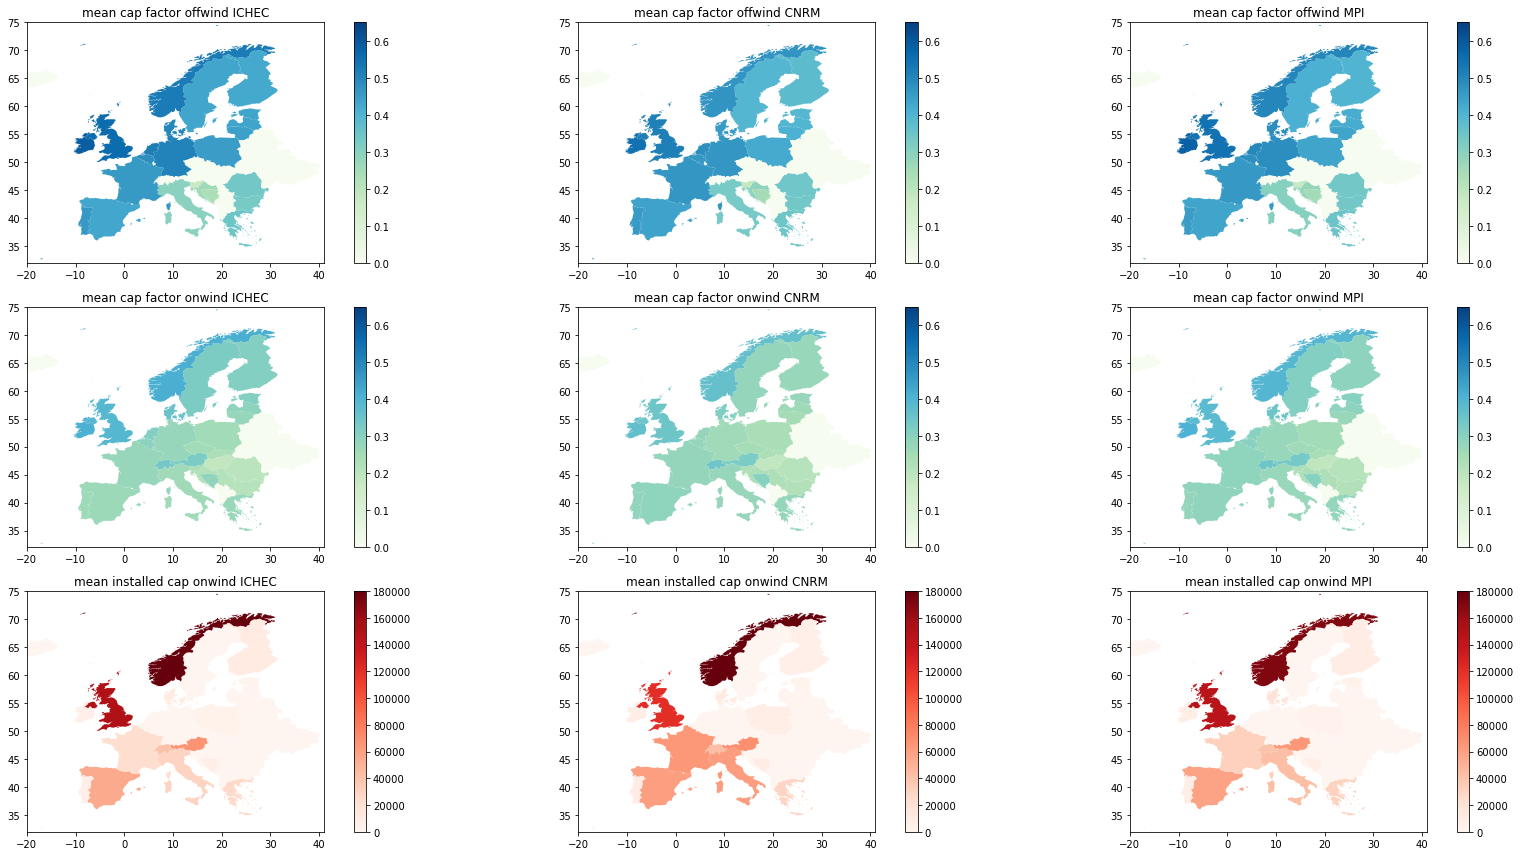

In [126]:
fig, axes = plt.subplots(3,3, figsize=(24,12))
for i, m in enumerate(models):
    carrier = 'offwind'
    for j, carrier in enumerate(['offwind', 'onwind']):
        key_factor = 'mean cap factor {} {}'.format(carrier, m)
        ax = axes[j,i]
        europe.plot(key_factor, ax=ax, legend=True, cmap='GnBu', vmin=0., vmax=0.65)
        ax.set_title(key_factor)
        ax.set_xlim(-20,41)
        ax.set_ylim(32,75)
for i, m in enumerate(models):
    carrier = 'onwind'
    j = 2
#     for j, carrier in enumerate(['offwind', 'onwind']):
    key_cap = 'mean cap share {} {}'.format(carrier, m)
    ax = axes[j,i]
    vmin, vmax = [0, 180000]
    europe.plot(key_cap, ax=ax, legend=True, cmap='Reds', vmin=vmin, vmax=vmax)
    ax.set_title('mean installed cap {} {}'.format(carrier, m))
    ax.set_xlim(-20,41)
    ax.set_ylim(32,75)
    
fig.tight_layout()
fig.show()

In [127]:
fig.savefig("figs/capacity_factor_offwind_onwind_country_map_v2.png",bbox_inches='tight')

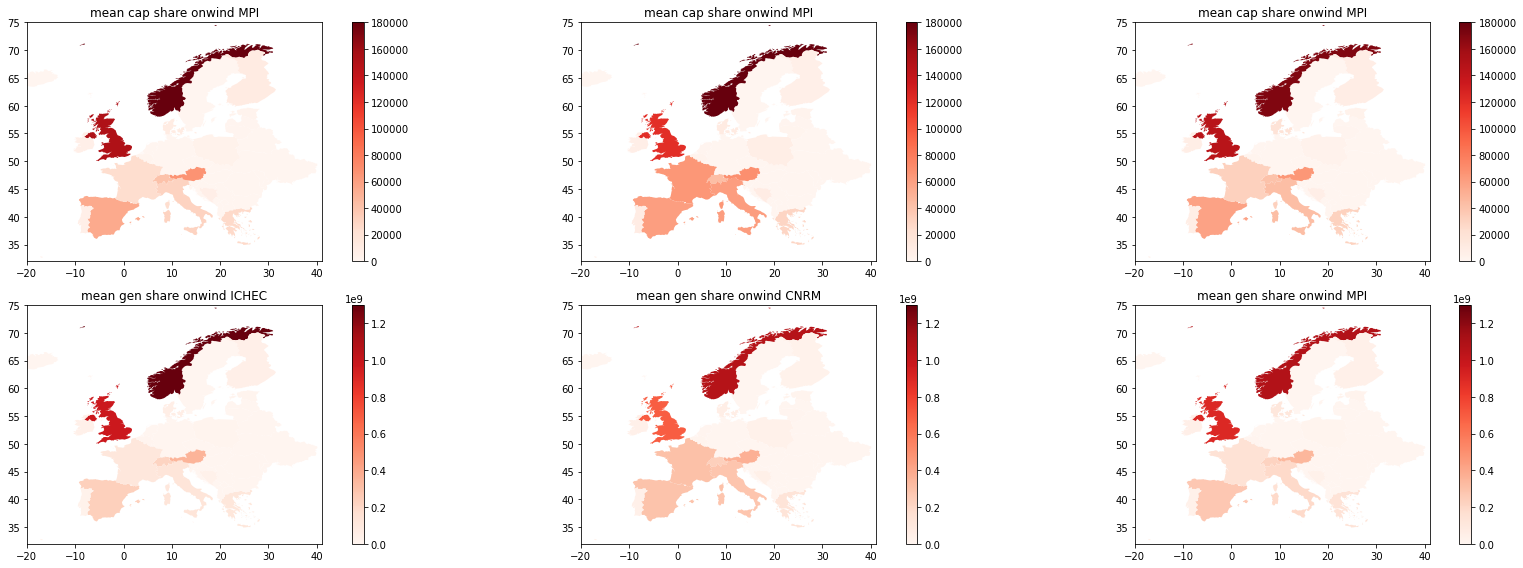

In [111]:
fig, axes = plt.subplots(2,3, figsize=(24,8))
for i, m in enumerate(models):
    carrier = 'onwind'
    j = 0
#     for j, carrier in enumerate(['offwind', 'onwind']):
    key_cap = 'mean cap share {} {}'.format(carrier, m)
    ax = axes[j,i]
    vmin, vmax = [0, 180000]
    europe.plot(key_cap, ax=ax, legend=True, cmap='Reds', vmin=vmin, vmax=vmax)
    ax.set_title(key_factor)
    ax.set_xlim(-20,41)
    ax.set_ylim(32,75)
    key_gen = 'mean gen share {} {}'.format(carrier, m)
    j = 1
    ax = axes[j,i]
    vmin, vmax = [0, 1.3e9]
    europe.plot(key_gen, ax=ax, legend=True, cmap='Reds', vmin=vmin, vmax=vmax)
    ax.set_title(key_gen)
    ax.set_xlim(-20,41)
    ax.set_ylim(32,75)
fig.tight_layout()
fig.show()